# **CS224W - Colab 3**

在 Colab2 中，我们用 `PyG` 搭建了一个GNN模型。在本次实验中，我们将实现**GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) 和 **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) 网络。然后在 CORA 数据集上跑我们的模型，CORA 数据集是一个标准引用网络评测数据集。

然后，我们将在不同的设置下分割图并对数据集加以变化，其中会使用到 Python 用来帮助进行高性能图深度学习的库——[DeepSNAP](https://snap.stanford.edu/deepsnap/) 库。

最后，使用 DeepSNAP 的直推式连接预测分割功能，我们搭建了一个用来进行连接预测任务的简单 GNN 模型。

**注意**：确保顺序执行所有代码单元，否则变量或库无法在之后的单元中使用。实验愉快 ：）

> 在实验开始之前，请确保正确安装了 [PyG](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) 以及 [DeepSNAP](https://snap.stanford.edu/deepsnap/notes/installation.html) 第三方库。

In [1]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

## 1 GNN 层

在 Colab2 中，我们实现了用来进行结点和图分类任务的模型。但是，其中用到的 `GCNConv` 是官方库中提供的模块。在本实验中，我们会提供格尼一个通用的GNN堆叠框架，你可以将你自己实现的 `GraphSAGE` 模块和 `GAT` 模块插入。我们会使用最终实现来在 CORA 数据集上进行结点分类测试。在这个数据集中，结点是文档，边是无向引用。每个结点都有一个类标签。结点特征是文档的 Bag of Words 表征。在 Cora 数据集中，一共有2708个结点、5429条边，以及7个结点类别，并且每个结点都有1433维特征。

### GNN 堆叠模块

下面是可以插入任何层的通用GNN模块，包括 **GraphSage** 和 **GAT** 等。你只需要将自己的 **GraphSage** 和 **GAT** 模块作为组件插入其中即可。

In [2]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        assert args.num_layers >= 1, 'Number of layers is not >=1'
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        # In case of multi-head attention mechanism is applied,
        # here we make the size of convolution model input being
        # num_heads * hidden_dim and so does the post-message processing layer.
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.convs.extend([conv_model(args.heads * hidden_dim, hidden_dim)
            for _ in range(args.num_layers-1)])

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim),
            nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim)
        )
        self.dropout = args.dropout
        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, _ = data.x, data.edge_index, data.batch
          
        for conv in self.convs: # range(self.num_layers):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        return x if self.emb else F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

### 实现 GraphSage

现在开始实现我们自己的网络层！这一部分可以让你熟悉一下如何基于消息传递（Message Passing）实现网络层。你将实现 `forward`、`message` 以及 `aggregate` 方法。

总的来说，`forward` 方法是信息传递发生的地方。在一次迭代内的所有东西都发生在 `forward` 里，其中包括调用 `propagate` 方法来将邻域结点的信息（information）传播到中央结点。一般来说是预处理 -> 传播 -> 后处理。

一般来说，`propagate` 会进行三个步骤：

1. 调用 `message` 方法来把邻域结点的信息（information）转变为消息（message）；
2. 调用 `aggregate` 来将所有消息从邻域聚合为一；
3. 调用 `update` 方法会进一步生成下一次迭代的结点嵌入。

但是我们的实现和上述过程稍微有些不一样，因为我们不会实现 `update`，而是将更新结点的逻辑放在 `forward` 方法中。更具体点来说，在信息（information）传播之后，我们直接在 `propagate` 的结果上进行一些操作，使得 `forward` 结果刚好是这次迭代完之后的节点嵌入。

除此之外，传递给 `propagate` 函数当参数的张量也可以通过在变量名后加上 `_i` 或 `_j` 后缀来映射为结点 $i$ 和结点 $j$ 相关的张量，比如 $x_j$ 和 $x_j$。注意我们用 $i$ 指代中央节点，用 $j$ 指代邻居结点。

注释里会有更多细节。值得注意的是，我们在 **GraphSAGE** 里加入了 **Skip Connection**。更新规则可以用公式更正式地描述为：

$$
\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}
$$

简单起见，我们这里使用了平均聚合，其中

$$
\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}
$$

除此之外, 每次迭代都会加入 $\ell$-2 正则。

> 为了正确地实现，我们得先理解下各个方法之间如何互动。在`propagate` 中，我们传入任何需要地参数。比如，我们将 `x` 当成参数传入：
> 
> $$
> \dots = propagate(\dots, x=(x_\text{central}, x_\text{neighbor}), \dots)
> $$
> 
> 这里的 $x_\text{central}$ 和 $x_\text{neighbor}$ 分别代表来自中央和邻域的结点。如果中央和邻域的结点的表征是同一套表征，则 $x_\text{central}$ 和 $x_\text{neighbor}$ 一样。
> 
> 不妨假设 $x_\text{central}$ 和 $x_\text{neighbor}$ 的形状都是 $N\times d$，其中 $N$ 是结点个数，$d$ 是特征维度。
> 
> 那么在 `message` 方法中，我们可以取叫做 `x_i` 和 `x_j` 的参数，则这里的 `x_i` 和 `x_j` 的形状都是 $E\times d$，而不是 $N\times d$！`x_i`是通过将所有边中的中央结点拼接起来生成的，类似地，`x_j` 是通过将所有边中的邻居结点拼接起来生成的。
> 
> 让我们看看例子。假设我们有四个结点，所以 $x_\text{central}$ 和 $x_\text{neighbor}$ 的形状是 $4\times d$。我们有两条边 (1, 2) 和 (3, 0)，因此 $x_i$ 是$\left[x_\text{central}[1]; x_\text{central}[3]\right]$, `x_j` 为$\left[x_\text{central}[2]; x_\text{central}[0]\right]$。
> 
<font color='red'>接下来的问题请不要参考网上的实现！</font>

In [3]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True, bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = Linear(in_channels, out_channels, bias=bias)
        self.lin_r = Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        out = self.propagate(edge_index, x=(x,x), size=size)     # first argument in x=(x,x) is x_j, the second is x_i
        out = self.lin_l(x) + out
        return F.normalize(out, p=2) if self.normalize else out

    def message(self, x_j):
        return self.lin_r(x_j)

    def aggregate(self, inputs, index):
        # The axis along which to index number of nodes.
        node_dim = self.node_dim
        
        # Aggregation
        return torch_scatter.scatter(inputs, index, node_dim, reduce="mean")


### 实现 GAT

注意力机制现在在许多基于次序的任务中成为了 Sota 模型，比如机器翻译、学习句子表征等任务。注意力机制的一个主要好处就是它能关注输入中最相关的部分来做出决策。在本次实验中，让我们通过使用 `GAT` 来看看如何使用注意力机制进行图结构数据的结点分类任务。

GAT 的基础模块就是图注意力层，是聚合函数的一种变体。假设有 $N$ 个结点，每个结点有 $F$ 维特征向量。则每个图注意力层的输入都是结点特征的集合：$\mathbf{h} = \left\{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}\right\}$，$\overrightarrow{h_i} \in R^F$，输出则是新的结点特征集，但是维度可能变成了 $F^\prime$：$\mathbf{h^\prime} = \left\{\overrightarrow{h_1^\prime}, \overrightarrow{h_2^\prime}, \dots, \overrightarrow{h_N^\prime}\right\}$，其中 $\overrightarrow{h_i^\prime} \in \mathbb{R}^{F^\prime}$。

我们现在来讲讲图注意力层如何将输入特征转化成更高级别的特征。首先，每个结点都需要经过一个公用的线性变换，即参数矩阵$\mathbf{W} \in \mathbb{R}^{F^\prime \times F}$。然后，再给每个结点加上自注意力机制：

$$
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}
$$

这个机制会计算出注意力系数，而注意力系数则代表结点 $j$ 的特征对于结点 $i$ 的重要程度：

$$
\begin{equation}
e_{ij} = a\left(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j}\right)
\end{equation}
$$

最一般的自注意力机制就是丢掉结构信息，然后每个结点都对其他所有结点计算注意力。但为了使用图结构信息，我们在注意力机制中使用的是掩码注意力（masked attention）。在掩码注意力中，我们只计算邻域结点的注意力系数 $e_{ij}$。

为了方便比较不同结点的系数，我们关于 $j$ 对系数使用 softmax 函数进行了归一化：

$$
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}
$$

我们的注意力机制 $a$ 是一个单层前播神经网络，其中的参数为$\overrightarrow{a} \in \mathbb{R}^{F^\prime}$，之后会有一个 LeakyReLU 非线性（负数输入的斜率是0.2）。让我们将 $\cdot^\top$ 记为转置，记 $\|$ 为拼接，则我们注意力机制则可以用公式表述为

$$
\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^\top \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^\top\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^\top \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^\top\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}
$$

在后续问题中，我们约定：$\alpha_l = [...,\overrightarrow{a_l}^\top \mathbf{W_l} \overrightarrow{h_i},...]$ 以及 $\alpha_r = [..., \overrightarrow{a_r}^\top \mathbf{W_r} \overrightarrow{h_j}, ...]$。

在 GAT 中的每一层中，计算完注意力系数之后，聚合函数的结果都可由邻域消息加权求和得到，其中权重都由 $\alpha_{ij}$ 指定。

目前，我们通常使用使用归一化的注意力系数来计算邻域内特征的线性组合。这些聚合结果最终就是输出的结点特征。

$$
\begin{equation}
h_i^\prime = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}
$$

为了稳定自注意力的学习过程，我们采用多头注意力机制。即使用 $K$ 个独立的注意力机制，或者叫“头”，来计算出上式的输出特征。然后我们将这些输出特征拼接起来：

$$
\begin{equation}
    \overrightarrow{h_i}^\prime = \|_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}
$$

其中 $\|$ 是拼接，$\alpha_{ij}^{(k)}$ 是 $k$ 头归一化的注意力机制 $(a^k)$，且 $\mathbf{W}^{(k)}$ 是对应输入线性变换的权重矩阵。注意，在当前情况下，$\mathbf{h'} \in \mathbb{R}^{KF'}$。

In [4]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2, negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        # Linear transformation shared by central node and neighbor nodes,
        # i.e. W_l and W_r. The feature dimension will transformed from F to F'.
        self.lin_l = Linear(in_channels, heads * out_channels)
        self.lin_r = self.lin_l

        # multi-head attention mechanism for central node and neighbor nodes respectively.
        self.att_l = Parameter(torch.randn(heads, out_channels), requires_grad=True)
        self.att_r = Parameter(torch.randn(heads, out_channels), requires_grad=True)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x: Tensor, edge_index: Adj, size = None):
        
        H, C = self.heads, self.out_channels

        x_l: Tensor = self.lin_l(x).view(-1, H, C)
        x_r: Tensor = self.lin_r(x).view(-1, H, C)
        alpha_l, alpha_r = (self.att_l * x_l).sum(dim=-1, keepdim=True), (self.att_r * x_r).sum(dim=-1, keepdim=True)
        
        # Propagate
        out = self.propagate(edge_index, size=size, x=(x_r, x_l), alpha=(alpha_r, alpha_l))

        # reshape the tensor
        return out.view(-1, H * C)


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        # 1. Calculate attention weights and apply leaky relu.
        alpha_ij: Tensor = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        # 2. Use the softmax imported from torch_geometric.utils to normalize
        alpha_ij: Tensor = softmax(alpha_ij, index=index, ptr=ptr, num_nodes=size_i)
        # 3. Apply dropout to attention weights
        alpha_ij: Tensor = F.dropout(alpha_ij, p=self.dropout, training=self.training)
        # 4. Multiply embeddings
        return alpha_ij * x_j


    def aggregate(self, inputs, index, dim_size = None):
        return torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce="sum")

### 构建优化器

这个函数已经替你实现了。

In [5]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

### 训练和测试

这里我们给你提供了训练和测试的函数。

In [6]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, **d):
        self.__dict__ = d


### 开始训练！

我们将在 CORA 数据集上进行结点分类任务。这一部分已经替你实现好了。

Node task. test set size: 140
Maximum accuracy: 0.744
Minimum loss: 0.10387597978115082
Node task. test set size: 140
Maximum accuracy: 0.75
Minimum loss: 0.01981864497065544


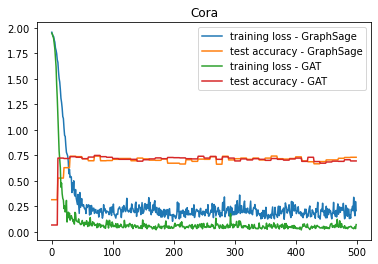

In [7]:
def main():
    args = objectview(
        model_type="GraphSage",
        dataset="cora",
        num_layers=2,
        heads=1,
        batch_size=32,
        hidden_dim=32,
        dropout=0.5,
        epochs=500,
        opt="adam",
        opt_scheduler="none",
        opt_restart=0,
        weight_decay=5e-3,
        lr=0.01
    )
    for model_type in ["GraphSage", "GAT"]:
        args.model_type = model_type
        args.heads      = 2 if model_type == "GAT" else 1
        dataset         = Planetoid(root="./dataset/", name="Cora")

        test_accs, losses = train(dataset, args)
        print(f"Maximum accuracy: {max(test_accs)}")
        print(f"Minimum loss: {min(losses)}")

        plt.title(dataset.name)
        plt.plot(losses, label=f"training loss - {model_type}")
        plt.plot(test_accs, label=f"test accuracy - {model_type}")
    plt.legend()
    plt.show()


if __name__ == '__main__':
    main()

### 问题 1.1：你能使用GraphSAGE在测试集上获得的最大准确度是多少？

### 问题 1.2：你能使用GAT在测试集上获得的最大准确度是多少？

## 2 DeepSNAP 基础

之前的实验中，我们使用了图类（`NetworkX`）和张量（`PyG`）来表征图。图类`nx.Graph`提供了丰富的分析和操作功能，比如聚合系数和PageRank。为了将图喂进模型，我们得把图用张量表征，包括边张量`edge_index`和结点特征`x`及标签`y`。但是只用张量会让图操作和分析变得困难且低效。所以，本实验中我们将使用既能提供表征方式，又能提供GNN训练、验证、测试完整流水线的 DeepSNAP。

概括来说，[DeepSNAP](https://github.com/snap-stanford/deepsnap) 是一个 Python 库，可以辅助我们进行高效的图深度学习。DeepSNAP 支持灵活的图操作，标准流水线，以及异构图和简单的API。

1. DeepSNAP 可以很容易地在训练前或中进行复杂地图操作，比如特征计算，预训练，子图抽取等。
2. 在大多数框架中，归纳式或是直推式的结点、边、以及图任务的标准流水线都得用户来编码。实际上，还涉及到一些额外的选择（比如如何分割用于连接预测的数据集）。DeepSNAP 提供了这样的标准流水线，节省了很多编码的时间，并且让不同模型之间的比较更加公平。
3. 许多现实世界的数据集是异构网络，但是支持异构网络（包括数据存储和灵活的消息传递）的库很少。DeepSNAP提供了一套高效灵活、支持结点和边异构的工具。

[DeepSNAP](https://github.com/snap-stanford/deepsnap) 是最新发布的项目，且仍在开发。如果你发现了任何 bug 或有任何改进想法，请随时在 GitHub 上提出 issue 或是发起 pull requests。

本次实验中，我们将关注于 DeepSNAP 中的图操作和分割功能。

### 配置

In [8]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

def visualize(G, color_map=None, seed=123):
  if color_map is None:
    color_map = '#c92506'
  plt.figure(figsize=(8, 8))
  nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), \
                                 label=None, node_color=color_map, node_shape='o', node_size=150)
  edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)
  if color_map is not None:
    plt.scatter([],[], c='#c92506', label='Nodes with label 0', edgecolors="black", s=140)
    plt.scatter([],[], c='#fcec00', label='Nodes with label 1', edgecolors="black", s=140)
    plt.legend(prop={'size': 13}, handletextpad=0)
  nodes.set_edgecolor('black')
  plt.show()

### DeepSNAP 图

`deepsnap.graph.Graph` 类是 DeepSNAP 中的核心类。它不仅将图表征为张量，还引用了来自图操作包的图对象。

目前 DeepSNAP 支持 [NetworkX](https://networkx.org/) 和 [Snap.py](https://snap.stanford.edu/snappy/doc/index.html) 作为图操作包后端。

本实验中，我们将使用 `Networkx` 作为后端图操作包。

首先来试试将一个简单的随机 `NetworkX` 图转化成 `DeepSNAP` 图。

(0, {'node_feature': tensor([0.9820, 0.1240, 0.3110, 0.1420, 0.6955]), 'node_label': tensor(1)})


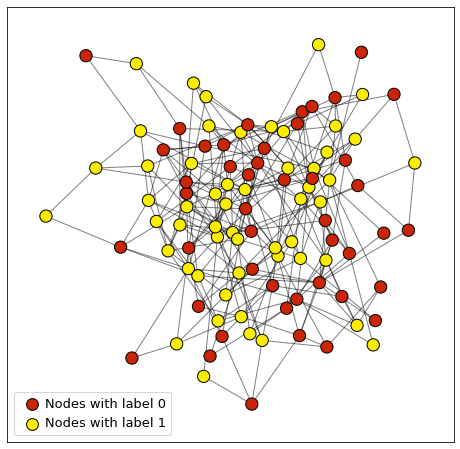

Graph(G=[], edge_index=[2, 524], edge_label_index=[2, 524], node_feature=[100, 5], node_label=[100], node_label_index=[100])
Node feature (node_feature) has shape torch.Size([100, 5]) and type torch.float32
Node label (node_label) has shape torch.Size([100]) and type torch.int64
Edge index (edge_index) has shape torch.Size([2, 524]) and type torch.int64
The DeepSNAP graph has <class 'networkx.classes.graph.Graph'> as the internal manupulation graph


In [9]:
num_nodes = 100
p = 0.05
seed = 100

# Generate a networkx random graph
G = nx.gnp_random_graph(num_nodes, p, seed=seed)

# Generate some random node features and labels
node_feature = {node : torch.rand([5, ]) for node in G.nodes()}
node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}

# Set the random features and labels to G
nx.set_node_attributes(G, node_feature, name='node_feature')
nx.set_node_attributes(G, node_label, name='node_label')

# Print one node example
for node in G.nodes(data=True):
  print(node)
  break

color_map = ['#c92506' if node[1].item() == 0 else '#fcec00' for node in G.nodes(data="node_label")]

# Visualize the graph
visualize(G, color_map=color_map)

# Transform the networkx graph into the deepsnap graph
graph = Graph(G)

# Print out the general deepsnap graph information
print(graph)

# DeepSNAP will convert node attributes to tensors
# Notice the type of tensors
print(f"Node feature (node_feature) has shape {graph.node_feature.shape} and type {graph.node_feature.dtype}")
print(f"Node label (node_label) has shape {graph.node_label.shape} and type {graph.node_label.dtype}")

# DeepSNAP will also generate the edge_index tensor
print(f"Edge index (edge_index) has shape {graph.edge_index.shape} and type {graph.edge_index.dtype}")

# Different from only storing tensors, deepsnap graph also references to the networkx graph
# We will discuss why the reference will be helpful later
print(f"The DeepSNAP graph has {type(graph.G)} as the internal manupulation graph")

DeepSNAP 有三级属性。在本例中有**结点级**属性，比如结点特征 `node_feature` 和结点标签 `node_label`。其他两级分别是**图级**和**边级**属性。用法和**结点级**类似，除了特征变成`edge_feature`或`graph_feature`，标签变成`edge_label`或`graph_label`等。

与 NetworkX 图类似，我们可以通过对象属性直接获取图的基本信息。

In [10]:
# Number of nodes
print(f"The random graph has {graph.num_nodes} nodes")

# Number of edges
print(f"The random graph has {graph.num_edges} edges")

The random graph has 100 nodes
The random graph has 262 edges


DeepSNAP 也提供了自动将 `PyG` 数据集对象转化成一个包含 `DeepSNAP` 图对象列表的函数。

这里我们将 `Cora` 数据集转化成 `DeepSNAP` 图的列表试试。

In [11]:
root = './dataset'
name = 'Cora'

# The Cora dataset
pyg_dataset= Planetoid(root, name)

# PyG dataset to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Get the first deepsnap graph (CORA only has one graph)
graph = graphs[0]
print(graph)

Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


### 问题2.1：CORA 图中有多少分类？特征维度又是多少？

In [12]:
def get_num_node_classes(graph):
  # TODO: Implement this function that takes a deepsnap graph object
  # and return the number of node classes of that graph.

  num_node_classes = graph.num_node_labels
  return num_node_classes

def get_num_node_features(graph):
  # TODO: Implement this function that takes a deepsnap graph object
  # and return the number of node features of that graph.

  num_node_features = graph.num_node_features
  return num_node_features

num_node_classes = get_num_node_classes(graph)
num_node_features = get_num_node_features(graph)
print(f"{name} has {num_node_classes} classes")
print(f"{name} has {num_node_features} features")

Cora has 7 classes
Cora has 1433 features


### DeepSNAP 数据集

现在，让我们来看看 DeepSNAP 数据集。一个 `deepsnap.dataset.GraphDataset` 会包含一列 `deepsnap.graph.Graph` 对象。除了 `deepsnap.graph.Graph` 对象之外，你也可以指定这个数据集会用来进行什么任务，比如**结点级**的任务（`task=node`），**边级**任务（`task=link_pred`）以及**图级**任务（`task=graph`）。

`deepsnap.dataset.GraphDataset` 也包含初始化时许多其他有用的参数以及其他功能。如果你很感兴趣，可以去看看[文档](https://snap.stanford.edu/deepsnap/modules/dataset.html#deepsnap-graphdataset)。

现在先使用有很多图的 COX2 数据集，并在初始化的时候指定任务为 `graph`。

In [13]:
root = './dataset'
name = 'COX2'

# Load the dataset through PyG
pyg_dataset = TUDataset(root, name)

# Convert to a list of deepsnap graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Convert list of deepsnap graphs to deepsnap dataset with specified task=graph
dataset = GraphDataset(graphs, task='graph')
print(dataset)

GraphDataset(467)


### 问题2.2：在COX2数据集索引为100的图中，标签是什么？

In [14]:
def get_graph_class(dataset, idx):
  # TODO: Implement this function that takes a deepsnap dataset object,
  # the index of the graph in the dataset, and returns the class/label 
  # of the graph (in integer).

  label = dataset[idx].graph_label.item()
  return label

graph_0 = dataset[0]
print(graph_0)
idx = 100
label = get_graph_class(dataset, idx)
print(f'Graph with index {idx} has label {label}')

Graph(G=[], edge_index=[2, 82], edge_label_index=[2, 82], graph_label=[1], node_feature=[39, 35], node_label_index=[39], task=[])
Graph with index 100 has label 0


### 问题2.3：在COX2数据集索引为200的图中，一共有多少边？

In [15]:
def get_graph_num_edges(dataset, idx):
  # TODO: Implement this function that takes a deepsnap dataset object,
  # the index of the graph in dataset, and returns the number of 
  # edges in the graph (in integer).

  num_edges = dataset[idx].num_edges
  return num_edges

idx = 200
num_edges = get_graph_num_edges(dataset, idx)
print(f'Graph with index {idx} has {num_edges} edges')

Graph with index 200 has 49 edges


## 3 DeepSNAP 进阶

我们已经学习了 DeepSNAP 的图和数据集的基本用法！

现在继续来学习一些高阶功能。

本小节我们会使用 DeepSNAP 进行特征计算和归纳式/直推式分割数据集。

### 配置

In [16]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

### 图的数据分割

图的数据分割可比 CV 和 NLP 难得多。总体来说，图的数据分割有两种，**归纳式**和**直推式**。

### 归纳式分割

正如 Lecture 中讲得，归纳式分割会将多个图分配到训练集、验证集以及测试集中。

下面是一个例子，是 DeepSNAP 在**图级任务**（图分类等）中进行归纳式分割。

In [17]:
root = './dataset'
name = 'COX2'

pyg_dataset = TUDataset(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as graph-level task such as graph classification
task = 'graph'
dataset = GraphDataset(graphs, task=task)

# Specify transductive=False (inductive)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

print(f"COX2 train dataset: {dataset_train}")
print(f"COX2 validation dataset: {dataset_val}")
print(f"COX2 test dataset: {dataset_test}")

COX2 train dataset: GraphDataset(373)
COX2 validation dataset: GraphDataset(46)
COX2 test dataset: GraphDataset(48)


### 直推式分割

在直推式分割中，训练集、验证集、测试集都是在一张图上。

这里我们在**结点级**任务中直推式地将 CORA 图分割。

> 注意在 DeepSNAP 中，默认是随机分割，但你也可以通过在从 `PyG` 中加载数据集时，指定 `fixed_split=True` 来进行固定分割，也可以直接改变 `node_label_index`。

In [18]:
root = './dataset'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Here we specify the task as node-level task such as node classification
task = 'node'

dataset = GraphDataset(graphs, task=task)

# Specify we want the transductive splitting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print(f"Cora train dataset: {dataset_train}")
print(f"Cora validation dataset: {dataset_val}")
print(f"Cora test dataset: {dataset_test}")

print(f"Original Cora has {dataset.num_nodes[0]} nodes")

# The nodes in each set can be find in node_label_index
print(f"After the split, Cora has {dataset_train[0].node_label_index.shape[0]} training nodes")
print(f"After the split, Cora has {dataset_val[0].node_label_index.shape[0]} validation nodes")
print(f"After the split, Cora has {dataset_test[0].node_label_index.shape[0]} test nodes")

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)
Original Cora has 2708 nodes
After the split, Cora has 2166 training nodes
After the split, Cora has 270 validation nodes
After the split, Cora has 272 test nodes


### 边级分割

与**结点级**和**图级**分割相比，**边级**分割有些麻烦。

通常在**边级**分割中，我们需要采样一些负边，将正边分配到不同数据集中，把训练边分为消息传递边和监督边，然后在训练的时候重新采样负边。

本小节将介绍`all`模式和`disjoint`模式，如果你对更多图分割的模式感兴趣，可以参考 DeepSNAP 数据集[文档](https://snap.stanford.edu/deepsnap/modules/dataset.html)。

#### `all` 模式

现在让我们从一个简单的**边级**分割模式开始，即 DeepSNAP 中的 `edge_train_mode="all"`。

In [19]:
root = './dataset'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Specify task as link_pred for edge-level task
task = 'link_pred'

# Specify the train mode, "all" mode is default for deepsnap dataset
edge_train_mode = "all"

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# Transductive link prediction split
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print(f"Cora train dataset: {dataset_train}")
print(f"Cora validation dataset: {dataset_val}")
print(f"Cora test dataset: {dataset_test}")

Cora train dataset: GraphDataset(1)
Cora validation dataset: GraphDataset(1)
Cora test dataset: GraphDataset(1)


在 DeepSNAP 中，监督边的索引都存储在 `edge_label_index` 张量中，对应的标签存放在 `edge_label` 张量中。

In [20]:
print(f"Original Cora graph has {dataset[0].num_edges} edges")
print(f"Because Cora graph is undirected, the original edge_index has shape {dataset[0].edge_index.shape}")

print(f"The training set has message passing edge index shape {dataset_train[0].edge_index.shape}")
print(f"The training set has supervision edge index shape {dataset_train[0].edge_label_index.shape}")

print(f"The validation set has message passing edge index shape {dataset_val[0].edge_index.shape}")
print(f"The validation set has supervision edge index shape {dataset_val[0].edge_label_index.shape}")

print(f"The test set has message passing edge index shape {dataset_test[0].edge_index.shape}")
print(f"The test set has supervision edge index shape {dataset_test[0].edge_label_index.shape}")

Original Cora graph has 5278 edges
Because Cora graph is undirected, the original edge_index has shape torch.Size([2, 10556])
The training set has message passing edge index shape torch.Size([2, 8444])
The training set has supervision edge index shape torch.Size([2, 16888])
The validation set has message passing edge index shape torch.Size([2, 8444])
The validation set has supervision edge index shape torch.Size([2, 2108])
The test set has message passing edge index shape torch.Size([2, 9498])
The test set has supervision edge index shape torch.Size([2, 2116])


我们可以看到在 `all` 模式下，训练集和验证集的消息传递边 `edge_index` 完全一样。除此之外，在训练集中，正监督边（`edge_label_index`）也和消息传递边一样。但是，在测试集中，消息传递边是训练集和验证集的并集。

注意 `edge_label` 和 `edge_label_index` 都有负边（默认情况下，有多少正边就有多少负边）。

现在，让我们实现个函数来看看两个存储着边索引的张量是否不相交，再看看更多的边分割属性。

#### 问题3.1-3.5：实现检查两个`edge_index`张量不相交的函数，然后回答后续的判断题。

In [21]:
def edge_indices_disjoint(edge_index_1: Tensor, edge_index_2: Tensor):
  # TODO: Implement this function that takes two edge index tensors,
  # and returns whether these two edge index tensors are disjoint.
  edges_1 = {tuple(edge) for edge in edge_index_1.T.detach().cpu().numpy()}
  edges_2 = {tuple(edge) for edge in edge_index_2.T.detach().cpu().numpy()}
  return len(edges_1 & edges_2) == 0

In [22]:
num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
print(f"3.1 Training (supervision) positve and negative edges are disjoint = \
        {edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)}")

num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
print(f"3.2 Validation (supervision) positve and negative edges are disjoint = \
        {edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)}")

num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
print(f"3.3 Test (supervision) positve and negative edges are disjoint = \
        {edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)}")

print(f"3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = \
        {edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)}")

print(f"3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = \
        {edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)}")

3.1 Training (supervision) positve and negative edges are disjoint =         True
3.2 Validation (supervision) positve and negative edges are disjoint =         True
3.3 Test (supervision) positve and negative edges are disjoint =         True
3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint =         True
3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint =         True


#### `Disjoint` 模式

现在来看看一个相对来说更复杂的直推式边分割案例，即 DeepSNAP 中 `edge_train_mode="disjoint"` 的模式，也是 Lecture 中讲的直推式链接预测分割。

In [23]:
edge_train_mode = "disjoint"

dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
orig_edge_index = dataset[0].edge_index
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_message_edge_index = dataset_train[0].edge_index
train_sup_edge_index = dataset_train[0].edge_label_index
val_sup_edge_index = dataset_val[0].edge_label_index
test_sup_edge_index = dataset_test[0].edge_label_index

print(f"The edge index of original graph has shape: {orig_edge_index.shape}")
print(f"The edge index of training message edges has shape: {train_message_edge_index.shape}")
print(f"The edge index of training supervision edges has shape: {train_sup_edge_index.shape}")
print(f"The edge index of validation message edges has shape: {dataset_val[0].edge_index.shape}")
print(f"The edge index of validation supervision edges has shape: {val_sup_edge_index.shape}")
print(f"The edge index of test message edges has shape: {dataset_test[0].edge_index.shape}")
print(f"The edge index of test supervision edges has shape: {test_sup_edge_index.shape}")

The edge index of original graph has shape: torch.Size([2, 10556])
The edge index of training message edges has shape: torch.Size([2, 6754])
The edge index of training supervision edges has shape: torch.Size([2, 3380])
The edge index of validation message edges has shape: torch.Size([2, 8444])
The edge index of validation supervision edges has shape: torch.Size([2, 2108])
The edge index of test message edges has shape: torch.Size([2, 9498])
The edge index of test supervision edges has shape: torch.Size([2, 2116])


可以看到，在两种模式下，训练集与验证集的消息传递边以及训练监督边的分割情况是不一样的。

#### 重新负采样

在训练阶段，每迭代一次，一般就要重新负采样一次。

下面我们把两次训练迭代过程中的训练集和验证集中的负边打印出来。

你应该能发现训练集中的负边被重新采样了。

In [24]:
dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
datasets = {}
follow_batch = []
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])
dataloaders = {
  split: DataLoader(
    ds, collate_fn=Batch.collate(follow_batch),
    batch_size=1, shuffle=(split=='train')
  )
  for split, ds in datasets.items()
}
neg_edges_1 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print(f"First iteration training negative edges:\t{neg_edges_1}")
  break
neg_edges_2 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print(f"Second iteration training negative edges:\t{neg_edges_2}")
  break

neg_edges_1 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print(f"First iteration validation negative edges:\t{neg_edges_1}")
  break
neg_edges_2 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print(f"Second iteration validation negative edges:\t{neg_edges_2}")
  break

First iteration training negative edges:	tensor([[ 819, 2157, 1839,  ...,  902, 2192, 1460],
        [1069, 2369,  665,  ...,  651,  550, 1049]])
Second iteration training negative edges:	tensor([[2191, 1598, 1195,  ...,  315, 2418,  632],
        [1694,  310,  910,  ..., 1902, 2199, 1037]])
First iteration validation negative edges:	tensor([[1665, 2478,  356,  ...,  923, 1151, 2417],
        [2571, 2675, 2600,  ..., 2614,  565, 1449]])
Second iteration validation negative edges:	tensor([[1665, 2478,  356,  ...,  923, 1151, 2417],
        [2571, 2675, 2600,  ..., 2614,  565, 1449]])


### 图转化 / 特征计算

DeepSNAP 另一个核心功能就是图转化 / 特征计算。

在 DeepSNAP中，我们将图转化 / 特征计算分成两种类型。一种是在训练前对整个数据集（`deepsnap.dataset`）进行转化，另一种是在训练时分批（`deepsnap.batch`）转化。

下面就是一个使用 NetworkX 作为后端来计算 PageRank 值并在训练前对张量进行更新的例子，即训练前对整个数据集转化。

In [25]:
def pagerank_transform_fn(graph):

  # Get the referenced networkx graph
  G = graph.G

  # Calculate the pagerank by using networkx
  pr = nx.pagerank(G)

  # Transform the pagerank values to tensor
  pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  pr_feature = pr_feature.view(graph.num_nodes, 1)

  # Concat the pagerank values to the node feature
  graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)

root = './dataset'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')
print(f"Number of features before transformation: {dataset.num_node_features}")
dataset.apply_transform(pagerank_transform_fn, update_tensor=False)
print(f"Number of features after transformation: {dataset.num_node_features}")

Number of features before transformation: 35
Number of features after transformation: 36


### 问题3.6：实现下面的转化并报告在COX2数据集图中（索引为406），结点（索引为3）的聚合系数是多少，小数点后取两位。

In [26]:
def cluster_transform_fn(graph):
  # TODO: Implement this function that takes an deepsnap graph object,
  # transform the graph by adding nodes clustering coefficient into the 
  # graph.node_feature
  clustering = nx.clustering(graph.G)
  clustering = torch.tensor([clustering[i] for i in range(graph.num_nodes)], dtype=torch.float32).view(-1, 1)
  graph.node_feature = torch.concat([graph.node_feature, clustering], dim=-1)

root = './dataset'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')

# Transform the dataset
dataset.apply_transform(cluster_transform_fn, update_tensor=False)

node_idx = 3
graph_idx = 406
node_feature = dataset[graph_idx].node_feature

print(f"The node has clustering coefficient: {round(node_feature[node_idx][-1].item(), 2)}")

The node has clustering coefficient: 0.17


除了能变化整个数据集，DeepSNAP 还可以在训练的时候进行批量（一般指`deepsnap.batch.Batch`）变化。

除此之外，DeepSNAP 还支持引用的图和其张量表征之间的变化同步。举个例子，你可以只在变化函数中修改 `NetworkX` 中的图对象，然后通过指定 `update_tensor=True`，该图对应的张量表征也会自动被修改。

更多信息请参考 DeepSNAP [文档](https://snap.stanford.edu/deepsnap/)。

## 4 边级预测

在上一节中，我们知道了 DeepSNAP 如何在链接预测的任务中直推式地分割边。

现在让我们使用 DeepSNAP 和 PyG 来实现**边级**预测，即链接预测模型。

In [27]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index

        # 1. Feed the node feature into the first conv layer
        node_feature = self.conv1(node_feature, edge_index)
        # 2. Add a ReLU after the first conv layer
        node_feature = F.relu(node_feature)
        # 3. Add dropout after the ReLU (with probability self.dropout)
        node_feature = F.dropout(node_feature, self.dropout, training=self.training)
        # 4. Feed the output to the second conv layer
        node_feature = self.conv2(node_feature, edge_index)
        # 5. select source and target node using edge_label_index, and calculate similarity by dot product
        source, target = node_feature[edge_label_index[0]], node_feature[edge_label_index[1]]
        return (source * target).sum(dim=-1)
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [28]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for batch in dataloaders['train']:
            
            batch.to(args["device"])

            optimizer.zero_grad()
            pred_y = model(batch)
            loss = model.loss(pred_y, batch.edge_label.type(torch.float32))
            loss.backward()
            optimizer.step()

            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)
            print(f"Epoch: {epoch:03d}, Train: {score_train:.4f}, Val: {score_val:.4f}, Test: {score_test:.4f}, Loss: {loss.item()}")

            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()

    score = 0
    for batch in dataloader:
        batch.to(args["device"])
        pred_y = torch.sigmoid(model(batch))
        score += roc_auc_score(batch.edge_label.cpu().detach(), pred_y.cpu().detach())
    score /= len(dataloader)
    return score

In [29]:
# Please don't change any parameters
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [30]:
pyg_dataset = Planetoid('./dataset', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
        graphs,
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(f"Train: {best_train_roc:.4f}, Val: {best_val_roc:.4f}, Test: {best_test_roc:.4f}")

Epoch: 001, Train: 0.5162, Val: 0.5138, Test: 0.4909, Loss: 0.6931764483451843
Epoch: 002, Train: 0.4938, Val: 0.5145, Test: 0.4915, Loss: 0.6931341290473938
Epoch: 003, Train: 0.5013, Val: 0.5154, Test: 0.4922, Loss: 0.6930963397026062
Epoch: 004, Train: 0.4891, Val: 0.5162, Test: 0.4933, Loss: 0.693098783493042
Epoch: 005, Train: 0.5177, Val: 0.5177, Test: 0.4945, Loss: 0.6930646300315857
Epoch: 006, Train: 0.5179, Val: 0.5187, Test: 0.4958, Loss: 0.6931133270263672
Epoch: 007, Train: 0.5112, Val: 0.5203, Test: 0.4974, Loss: 0.6931238174438477
Epoch: 008, Train: 0.5174, Val: 0.5218, Test: 0.4992, Loss: 0.6931315064430237
Epoch: 009, Train: 0.5240, Val: 0.5237, Test: 0.5010, Loss: 0.6931145787239075
Epoch: 010, Train: 0.5208, Val: 0.5254, Test: 0.5029, Loss: 0.6930732727050781
Epoch: 011, Train: 0.5334, Val: 0.5270, Test: 0.5051, Loss: 0.6930665969848633
Epoch: 012, Train: 0.5195, Val: 0.5288, Test: 0.5069, Loss: 0.6930192708969116
Epoch: 013, Train: 0.5360, Val: 0.5309, Test: 0.5088,

### 问题4：你最好的模型 `best_model` 在测试集上能获取到的 ROC-AUC 最高分是多少？